---
# Notebook 1: Gathering data
---

---

David Tersegno

4/1/22


The notebook uses the PushShift API to gather post information from Reddit's r/haskell, r/lisp, and r/lua subreddits. This data comes in JSON format, which is then converted to a pandas DataFrame. The exact parameters of what data is gathered is determined by a parameter dictionary that is passed when the request is made to the PushShift API host.

The repo and documentation for the API may be found here: [PushShift API](https://github.com/pushshift/api)

The API only collects 100 (or sometimes fewer) posts per request. In order to get 3000 post observations (1000 from each of the above subreddits), it must be called repeatedly.

The subreddit post data will be used to build a classifier model, which will be trained to predict whether a given post originated from r/haskell or r/lisp. The r/lua data collected is not used for the model, but the acquisition process and saved data is preserved for possible future use.

At the end of this notebook, the gathered data is saved in `'./data/'` relative to this notebook.


- [Import Libraries](#Import-Libraries)
- [Function Definitions](#Function-Definitions)
    - [get_subreddit](#get-subreddit)
    - [deep_into_subreddit](#deep-into-subreddit)
- [Get haskell data](#Get-haskell-data)
- [Plot cumulative posts over time](#Plot-cumulative-posts-over-time)
- [Plot the posting rate](#Plot-the-posting-rate)
- [How far back in time do these posts go?](#How-far-back-in-time-do-these-posts-go?)
- [Get Data for all subreddits](#Get-Data-for-all-subreddits)
    - [Save and export](#Save-and-export)

---
## Import Libraries

In [10]:
#import libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

plt.style.use('dark_background')

In [11]:
#explicitly list subreddits of interest
subreddits = ['haskell', 'lua', 'lisp']
pushshift_url_submissions = 'https://api.pushshift.io/reddit/search/submission'
pushshift_url_comments = 'https://api.pushshift.io/reddit/search/comment/'

---
---
## Function Definitions
---
This section defines some functions used later.

### get_subreddit

`get_subreddit(params, comments)` returns a pandas DataFrame of posts from requests.get() with `comments` a bool defining whether to gather comment data or normal posts.

`params` is a dictionary like the following:
```python
h_params = { #parameters for "submissions" request
    'subreddit':'haskell',
    'size':100,
    'aggs':'created_utc',
    'frequency':'day',
    'sort_type':'created_utc'
}
```

defining the post data to capture.

In [12]:
#define a data aquisition function
def get_subreddit(params, comments = False):
    if comments:
        the_url = pushshift_url_comments
    else:
        the_url = pushshift_url_submissions
    the_res = requests.get(the_url, params)
    the_status = the_res.status_code
    if the_status != 200:
        print(f'get_subreddit(): Request status code {the_status}')
        return None
    else:
        the_df = pd.DataFrame(the_res.json()['data'])
        return the_df

## deep_into_subreddit

Recursively collects data up to a certain number. From the outside, it works like
get_subreddit(), returning a DataFrame, but allowing a size parameter for the PushShift API call size to be >100.

It accomplishes this by repeatedly calling get_subreddit() a bunch of times.


In [13]:
#returns a df as if get_subreddit(), and ultimately requests.get(), allowed the
# size parameter to be larger than 100. This will chop off any remainder, total_size mod 100.
def deep_into_subreddit(params: dict, comments = False, verbose = False):
    size_left = params['size'] #grab the total size called
    params_copy = dict(params) #copy params to use and edit ahead in repeated get_subreddit() calls
    params_copy['size'] = 100 #set the parameter size down to 100 to use in a get_subreddit() call later
    OK_response_code = True #will trigger the premature end of the next loop
    df_list = [] #this will fill with dfs, each of 100 posts before the last
    last_post_time = datetime.MAXYEAR #will keep track of the last post time,
    last_max_index = -1 #will be used to assign indices properly
    while(size_left >= 100 and OK_response_code): #while there are still posts to grab (and nothing's gone wrong...)
        if size_left%500==0 and verbose:
            print(f'{size_left} left to gather for {params["subreddit"]}')
        new_df = get_subreddit(params_copy, comments) #repeatedly call get_subreddit()...
        size_left -= 100 # reduce the size_left by 100 each loop
        if type(new_df) != type(pd.DataFrame([])): #check if we got values in a dataframe
            OK_response_code = False  #end the loop if not
            print("deep_into_subreddit(): API call returned nothing.")
        else:
            last_post_time = new_df['created_utc'].min()# lower last_post_time to the oldest post's age
            params_copy['before'] = last_post_time #tells the call to search for earlier posts.
            new_df_length = len(new_df)
            if new_df_length != 100 and verbose:
                print(f'gathered only {len(new_df)} entries from previous call')
            new_df.index = np.linspace(last_max_index+1,last_max_index+new_df_length, new_df_length) #assign new indices to the data so they don't interfere with the previous data
            last_max_index = new_df.index.max() #get the largest index in the set to compare next loop
        df_list.append(new_df) #...and append the result to the df_list.
    concatenated_df = pd.concat(df_list) #when the loop's done, concatenate all the dfs...
    print(f'finished gathering for {params["subreddit"]}.')
    return concatenated_df #... and return it.
        
    
    

---
## Get haskell data

Gather data from r/haskell to get a sense of the format.

In [14]:
deep_h_params = { #create a list of params to search deeper than 100 posts
    'subreddit':'haskell',
    'size':500,
    'sort_type':'created_utc',
}

#get a bunch of posts.
my_haskell_df = deep_into_subreddit(deep_h_params)

finished gathering for haskell.


In [15]:
#take a look at the DataFrame info: column names, non-null value count per column, and data types.
my_haskell_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 500 entries, 0.0 to 499.0
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  500 non-null    object 
 1   allow_live_comments            500 non-null    bool   
 2   author                         500 non-null    object 
 3   author_flair_css_class         0 non-null      object 
 4   author_flair_richtext          500 non-null    object 
 5   author_flair_text              1 non-null      object 
 6   author_flair_type              500 non-null    object 
 7   author_fullname                500 non-null    object 
 8   author_is_blocked              500 non-null    bool   
 9   author_patreon_flair           500 non-null    bool   
 10  author_premium                 500 non-null    bool   
 11  awarders                       500 non-null    object 
 12  can_mod_post                   500 non-null 

## Plot cumulative posts over time

The slope of this plot is the posting rate.

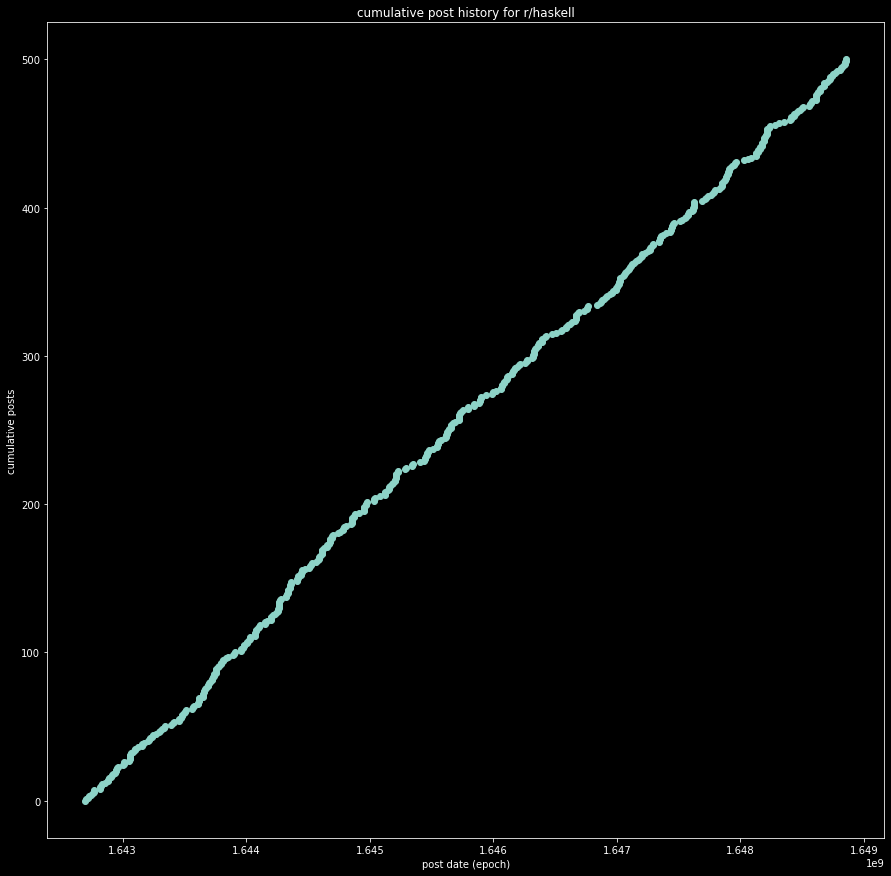

In [16]:
# unfortunately can't just use .plot() on the time series --- I want the transpose of that
plt.figure(figsize =(15,15))
plt.scatter(my_haskell_df['created_utc'].sort_values(),np.linspace(0,500,500))
plt.xlabel("post date (epoch)")
plt.ylabel('cumulative posts')
plt.title('cumulative post history for r/haskell');

It looks like people are more likely to post during certain times. There is definitely seasonality here. It would be interesting to see what happens when we do an FFT on this data --- are there characteristic frequencies? Or just see how the function looks treated as oscillating with days, weeks, months.

It may be easier to see the posting rate itself. Make a list of successive differences for the above to start constructing this.

## Plot the posting rate

In [65]:
#construct differences in epochs
epoch_list = list(my_haskell_df['created_utc'])
epoch_diffs = [
    epoch_list[index+1] - epoch_list[index]
    for index in range(len(epoch_list)-1)
]
#it's one shorter than the original list.

In [66]:
#construct differences in cumulative posts
# they're all 1 post.
post_diffs = np.ones(len(epoch_diffs))

In [67]:
len(post_rate)

499

(0.0, 0.001)

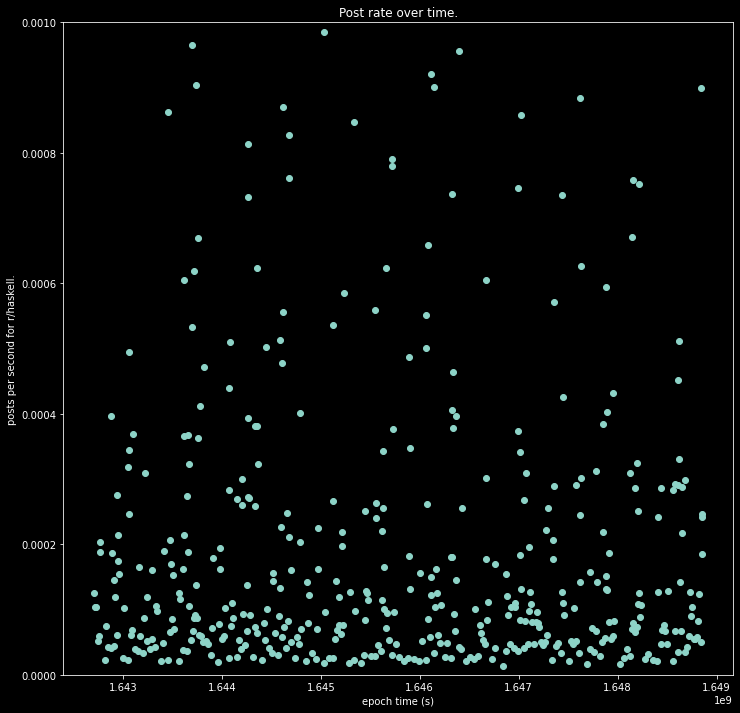

In [74]:
#make post_rate
post_rate = -post_diffs / epoch_diffs

#plot the post_rate
plt.figure(figsize=(12,12));
plt.scatter(epoch_list[:-1],post_rate);
plt.title("Post rate over time.")
plt.ylabel("posts per second for r/haskell.")
plt.xlabel('epoch time (s)')
plt.ylim(0,0.001)

It's tough to see any clear pattern by sight. We could tackle that problem in a future revision of this project.

### How far back in time do these posts go?

In [17]:
#earliest 'created_utc'
my_haskell_df.loc[0,'created_utc']

1648857554

Using [this Stack Overflow](https://stackoverflow.com/questions/12400256/converting-epoch-time-into-the-datetime) for help with converting epoch time to a datetime.

In [75]:
#the conversion results in a datetime object.
# convert an epoch time to see the form of the returned datetime object
epochtime = my_haskell_df.loc[1,'created_utc']
date_time = datetime.datetime.fromtimestamp(epochtime)
print(date_time)

2022-04-01 18:50:27


In [264]:
#create a date column from the 'created_utc' column
my_haskell_df['date'] = my_haskell_df['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [265]:
my_haskell_df['date']

0.0     2022-03-28 19:05:06
1.0     2022-03-28 16:56:05
2.0     2022-03-28 11:03:34
3.0     2022-03-28 06:55:03
4.0     2022-03-28 03:16:59
                ...        
495.0   2022-01-16 08:04:13
496.0   2022-01-16 03:09:19
497.0   2022-01-15 23:29:33
498.0   2022-01-15 19:44:18
499.0   2022-01-15 19:12:48
Name: date, Length: 500, dtype: datetime64[ns]

500 posts corresponds to over 3 months of posts from mid January 2022 to end of March.

In [266]:
#get the size of the range of dates as a timedelta object
timespan = my_haskell_df['date'].max()-my_haskell_df['date'].min()

In [267]:
#find the post rate in posts per day
haskell_post_rate = 500/timespan.total_seconds()
haskell_post_rate*86400

6.944960225634041

About 7 posts per day. A year's worth would be 2555 posts. Let's get a few months' worth of posts from each. 

# Get Data for all subreddits

Occasionally the API call only gets 99 results. I couldn't say why. deep_into_subreddit sees it as a normal request (code 200).

Let's grab 1000 posts from r/haskell, r/lisp, and r/lua each, as well as the latest 1000 comments from each.

In [77]:
#list subreddits to get data from.
interesting_subreddits = ['haskell','lisp','lua']

#create a list of params to search 1000 posts
deep_params = {
    'subreddit':'haskell',
    'size':1000,
    'sort_type':'created_utc'
}

#comment parameters
deep_params_c = {
    'subreddit':'haskell',
    'size':1000,
    'sort_type':'created_utc'
}
 
#a dictionary to hold the subreddit data
subreddit_dfs = {  
    'haskell': pd.DataFrame([]),
    'lua':pd.DataFrame([]),
    'lisp':pd.DataFrame([])
}

#a dictionary to hold the comment data
subreddit_c_dfs = {  
    'haskell': pd.DataFrame([]),
    'lua':pd.DataFrame([]),
    'lisp':pd.DataFrame([])
}


#### collect data #####
for subreddit in interesting_subreddits:       # for each interesting subreddit,
    deep_params['subreddit']=subreddit             # set the parameter subreddit
    this_df = deep_into_subreddit(deep_params, verbose= True)    # get a dataframe of the post data
    this_c_df = deep_into_subreddit(deep_params_c, comments=True , verbose = True)  #get a dataframe of comment data
    subreddit_dfs[subreddit] = this_df             # add post dataframe to the dictionary
    subreddit_c_dfs[subreddit] = this_c_df         #add comments dataframe to the directory
print('done')

1000 left to gather for haskell
500 left to gather for haskell
finished gathering for haskell.
1000 left to gather for haskell
500 left to gather for haskell
finished gathering for haskell.
1000 left to gather for lisp
500 left to gather for lisp
finished gathering for lisp.
1000 left to gather for haskell
500 left to gather for haskell
finished gathering for haskell.
1000 left to gather for lua
500 left to gather for lua
finished gathering for lua.
1000 left to gather for haskell
500 left to gather for haskell
get_subreddit(): Request status code 429
deep_into_subreddit(): API call returned nothing.
finished gathering for haskell.
done


## Save and export

In [53]:
#save the post data for use in a later notebook.
for subreddit in interesting_subreddits:
    subreddit_dfs[subreddit].to_csv(f'./data/{subreddit}.csv') #save posts
    subreddit_c_dfs[subreddit].to_csv(f'./data/{subreddit}_c.csv') #save comments

The data is saved in `./data/` relative to this notebook. It will be picked back up in Notebook 2, but never edited and saved over. Processed data is later stored in `./data_clean/` and `./data_clean_num/`.

Notebook 2 performs some EDA.